# Notebook 2: Vertical Slice Gravity wave

In the first notebook, we looked at the shallow water equations. Gusto can also solve the Boussinesq and Euler equations in their compressible or incompressible forms. This notebook we will demonstrate running the Compressible Euler equations with a gravity wave. \
In this equation set, we simulate the evolution of the velocity $\textbf{u}$, the dry density $\rho$, and the (virtual dry) potential temperature $\theta$. We will demostrate how to visualise a vertical slice of the potential temperature. 

The initial conditions for this are given in the paper: Klemp, J. B., Rotunno, R., & Skamarock, W. C. (1994). On the dynamics of gravity currents in a channel. Journal of Fluid Mechanics, 269, 169-198.

As our standard first step, we begin by importing the required libraries and functions from Firedrake and Gusto:

In [1]:
from petsc4py import PETSc
PETSc.Sys.popErrorHandler()
from gusto import *
import itertools
from firedrake import (as_vector, SpatialCoordinate, PeriodicIntervalMesh,
                       ExtrudedMesh, exp, sin, Function)
import numpy as np
import sys

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


Specify the time-step size, simulation duration, and frequency of output results.

In [2]:
dt = 6.
tmax = 3600.
dumpfreq = int(tmax / (2*dt))

For this vertical slice model, we firstly define a horizontal periodic interval mesh? We then choose the number of layers and columns we want to simulate in this flow. The periodic mesh is extruded in the vertical direction for this number of layers.

In [3]:
nlayers = 10  # horizontal layers
columns = 150  # number of columns
L = 3.0e5
m = PeriodicIntervalMesh(columns, L)

H = 1.0e4  # Height position of the model top
mesh = ExtrudedMesh(m, layers=nlayers, layer_height=H/nlayers)

To be able to examine point data across a vertical slice, we need to tell Gusto these locations.

In [4]:
points_x = np.linspace(0., L, 100)
points_z = [H/2.]
points = np.array([p for p in itertools.product(points_x, points_z)])

We will call the output folder 'sk_nonlinear'. We ensure that the simulation records the point data of the potential tempearture perturbation.

In [5]:
dirname = 'sk_nonlinear'

output = OutputParameters(dirname=dirname,
                          dumpfreq=dumpfreq,
                          pddumpfreq=dumpfreq,
                          dumplist=['u'],
                          perturbation_fields=['theta', 'rho'],
                          point_data=[('theta_perturbation', points)],
                          log_level='INFO')

Now, define the parameters and diagnostics we want to record. We are interested in the temperature gradients, which is automatically computed using the Gradient() function. As always, we then initialise the 'state' that will evolve with each time-step.

In [6]:
parameters = CompressibleParameters()
g = parameters.g
Tsurf = 300.

diagnostic_fields = [CourantNumber(), Gradient("u"),
                     Gradient("theta_perturbation"),
                     RichardsonNumber("theta", g/Tsurf), Gradient("theta")]

As always, we initialise the 'state' that will evolve with each time-step. We will solve the Compressible Euler Equations using order 1 Continuous Galerkin finite elements (I think?).

In [7]:
state = State(mesh,
              dt=dt,
              output=output,
              parameters=parameters,
              diagnostic_fields=diagnostic_fields)

eqns = CompressibleEulerEquations(state, "CG", 1)

gusto:INFO Physical parameters that take non-default values:
gusto:INFO 


Set up the initial conditions and define the thermodynamic constants.

In [8]:
# Initial conditions
u0 = state.fields("u")
rho0 = state.fields("rho")
theta0 = state.fields("theta")

# spaces
Vu = state.spaces("HDiv")
Vt = state.spaces("theta")
Vr = state.spaces("DG")

# Thermodynamic constants required for setting initial conditions
# and reference profiles
g = parameters.g
N = parameters.N
p_0 = parameters.p_0
c_p = parameters.cp
R_d = parameters.R_d
kappa = parameters.kappa

x, z = SpatialCoordinate(mesh)

# N^2 = (g/theta)dtheta/dz => dtheta/dz = theta N^2g => theta=theta_0exp(N^2gz)
Tsurf = 300.
thetab = Tsurf*exp(N**2*z/g)

theta_b = Function(Vt).interpolate(thetab)
rho_b = Function(Vr)

We compute a hydrostatic Exner pressure to ensure a hydrostatic balance, then  apply this to the initial state (is this correct?)

In [9]:
compressible_hydrostatic_balance(state, theta_b, rho_b)

We now set up the initial potential temperature profile. We apply a perturbation of:
$$\Theta' = \Delta \Theta \frac{sin(\pi \frac{z}{H})}{1 + \frac{(x-x_c)^2}{a^2}}$$

In [10]:
a = 5.0e3
deltaTheta = 1.0e-2
theta_pert = deltaTheta*sin(np.pi*z/H)/(1 + (x - L/2)**2/a**2)
theta0.interpolate(theta_b + theta_pert)
rho0.assign(rho_b)
u0.project(as_vector([20.0, 0.0]))

state.set_reference_profiles([('rho', rho_b),
                              ('theta', theta_b)])

Set up the linear solver and the time-stepper. As per the first notebook, we use Implicit Midpoint method for the velocity field, and an explicit SSPRK3 scheme for the other variables (density and potential temperature). This time, we need to specify the use of a compressible solver.

In [11]:
supg = True
if supg:
    theta_opts = SUPGOptions()
else:
    theta_opts = EmbeddedDGOptions()
transported_fields = [ImplicitMidpoint(state, "u"),
                      SSPRK3(state, "rho"),
                      SSPRK3(state, "theta", options=theta_opts)]

# Set up linear solver
linear_solver = CompressibleSolver(state, eqns)

# build time stepper
stepper = CrankNicolson(state, eqns, transported_fields,
                        linear_solver=linear_solver)

Next, you would solve the equations! However, they take ages to run, so we should not bother, or just run for a couple of time steps .... .

In [15]:
#Here's what you would do...
#stepper.run(t=0, tmax=tmax)

To save you having to run this full simulation, results have already been generated and stored in the 'results/sk_nonlinear' subdirectory. We will show a visualisation of the potential temperature at the points we specified earlier \
We set-up the visualisations that can be used in Jupyter notebook:

In [12]:
#from plotting import *
%matplotlib notebook
import matplotlib.pyplot as plt

In [13]:
from netCDF4 import Dataset
class Plotting(object):

    def __init__(self, filename, field_name, stats=None):

        # get data from file
        try:
            self.data = Dataset(filename, "r")
        except IOError:
            raise ValueError("File %s does not exist" % filename)

        # get time variable
        self.time = list(self.data.variables["time"])

        # get field
        try:
            self.grp = self.data.groups[field_name]
        except KeyError:
            raise ValueError("Field named %s does not exist in this file. You have these fields: %s" % (field_name, [str(f) for f in self.data.groups.keys()]))

        if stats is None:
            self.field = self.grp.variables[field_name]
        else:
            self.stats = []
            for stat in stats:
                try:
                    self.stats.append(self.grp.variables[stat])
                except KeyError:
                    raise ValueError("Stat named %s does not exist for this field. You have these stats: %s" % (stat, [str(s) for s in self.grp.variables.keys()]))


We will define a 1D plotting script for use in this notebook. More information about the plotting scripts and options can be found at https://github.com/firedrakeproject/gusto/tree/main/plotting. 

In [14]:
import argparse
import matplotlib.pyplot as plt
import numpy as np


class Plot1DProfile(Plotting):

    def __init__(self, filename, field_name, dim, val, time_entries=None):

        super().__init__(filename, field_name)

        # if no time_entries are specified, plot them all
        if time_entries is not None:
            # check that no time entries exceed the length of the time dimension
            if any(i > len(self.time) for i in time_entries):
                raise ValueError("You cannot plot a time entry greater than %i" % len(self.time))

            self.times = []
            for i in time_entries:
                self.times.append(self.time[i])
            print("Profile will be plotted for times %s :" % [str(t) for t in self.times])
        else:
            time_entries = [i for i in range(len(self.time))]
            self.times = self.time

        # get points
        points = self.grp.variables["points"]

        # check that user has fixed the values of all other dimensions
        if len(val) != points.shape[1]-1:
            raise ValueError("You must fix the values of exactly %s dimensions." % str(points.shape[1]-1))

        # find out which points satisfy requirements
        self.px = []
        idx = []
        for i, p in enumerate(points):
            pq = np.delete(p, [dim])
            if pq == val:
                self.px.append(p[dim])
                idx.append(i)

        if len(idx) == 0:
            raise RuntimeError("No points match your requirements")

        # field values
        self.f = self.field[time_entries, idx]

    def plot(self, same_plot):
        for i in range(len(self.times)):
            plt.plot(self.px, self.f[i], label='Time = {}'.format(self.times[i]))
            if not same_plot:
                plt.show()

        if same_plot:
            plt.show()



Now, we can visualise the potential temperature perturbation profile at the start, middle, and end of the simulation.

<IPython.core.display.Javascript object>


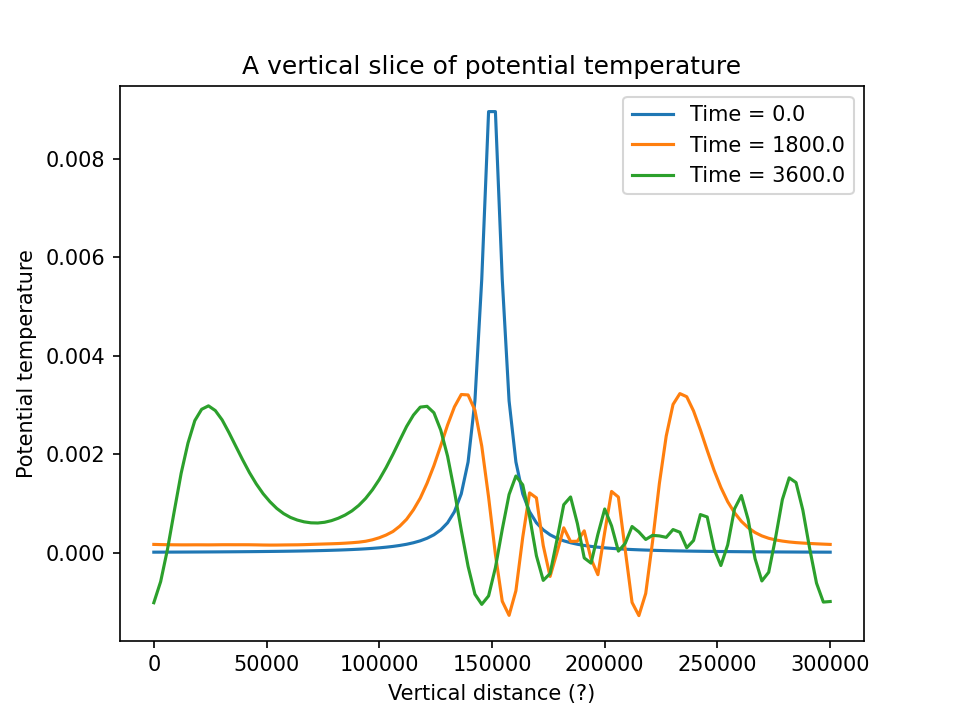

In [16]:
p = Plot1DProfile("results/sk_nonlinear/point_data.nc", "theta_perturbation", 0, [5000])
p.plot(same_plot='True')
plt.xlabel('Vertical distance (?)')
plt.ylabel('Potential temperature')
plt.title('A vertical slice of potential temperature')
plt.legend()

We can observe that we have an initial peak in the temperature perturbation at the centre of the domain, which disspates and is transported upwards during the simulation. 